In [1]:
import nltk
from nltk import pos_tag
from nltk.chunk import ne_chunk
from nltk.tree import Tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler

import pandas as pd

In [2]:
# nltk.download()

In [3]:
df = pd.read_csv("data/Aoutput0_cut.csv")
df.iloc[140]

frame                                                   8400
caption    An image of a man cutting a tomato with a knif...
Name: 140, dtype: object

In [4]:
captions = df["caption"]
# tokens = nltk.word_tokenize(captions[0])
tokens = [nltk.word_tokenize(caption) for caption in captions]
tagged_tokens = [nltk.pos_tag(token) for token in tokens]
tagged_tokens[140]

[('An', 'DT'),
 ('image', 'NN'),
 ('of', 'IN'),
 ('a', 'DT'),
 ('man', 'NN'),
 ('cutting', 'VBG'),
 ('a', 'DT'),
 ('tomato', 'NN'),
 ('with', 'IN'),
 ('a', 'DT'),
 ('knife', 'NN'),
 ('on', 'IN'),
 ('a', 'DT'),
 ('kitchen', 'NN'),
 ('counter', 'NN'),
 ('.', '.')]

In [5]:
df['tagged_tokens'] = tagged_tokens

In [6]:
def extract_SVO(tagged_token):
    subject = ""
    verb = ""
    obj = ""

    grammar = "SOV: {<DT>?<JJ>?<N.*><V.*><IN>?<DT>?<JJ>?<N.*>}"
    cp = nltk.RegexpParser(grammar)
    tree = cp.parse(tagged_token)
    for subtree in tree.subtrees():
        if subtree.label() == "SOV":
            for leaf in subtree.leaves():
                if ('NN' in leaf[1] and subject==''):
                    subject = leaf[0]
                if 'VB' in leaf[1]:
                    verb = leaf[0]
                if ('NN' in leaf[1]):
                    obj = leaf[0]
    return subject, verb, obj

In [7]:
def extract_NV(tagged_token):
    words = []

    for tag in tagged_token:
        if ('NN' in tag[1]):
            words.append(tag[0])
        if 'VB' in tag[1]:
            words.append(tag[0])
    return words[1:]

In [41]:
import numpy as np

svos = np.array([extract_SVO(tagged_token) for tagged_token in tagged_tokens])
df['vos'] = [tuple(vo) for vo in svos[:,1:]]
df['v'] = svos[:,1]
df['o'] = svos[:,2]
df.iloc[140]

frame                                                         8400
caption          An image of a man cutting a tomato with a knif...
tagged_tokens    [(An, DT), (image, NN), (of, IN), (a, DT), (ma...
vos                                              (cutting, tomato)
label                                                            4
v                                                          cutting
o                                                           tomato
Name: 140, dtype: object

In [33]:
df['v'].unique()

array(['playing', 'standing', 'stealing', '', 'walking', 'using',
       'looking', 'wearing', 'fixing', 'kneeling', 'opening', 'breaking',
       'sitting', 'pouring', 'holding', 'putting', 'cutting', 'chopping',
       'cleaning', 'cooking', 'preparing', 'bowed', 'clasped', 'dancing',
       'tossing'], dtype=object)

In [32]:
df['o'].unique()

array(['game', 'kitchen', 'chessboard', '', 'bottle', 'laptop', 'front',
       'reality', 'letter', 'document', 'toy', 'printer', 'lab', 'floor',
       'microwave', 'room', 'freezer', 'home', 'table', 'desk', 'package',
       'bag', 'plastic', 'condom', 'drawer', 'spray', 'pizza', 'tomato',
       'onion', 'pepper', 'tomatoes', 'plate', 'knife', 'peppers',
       'vegetables', 'strawberries', 'VR', 'lemon', 'wine', 'apple',
       'fruit', 'banana', 'meal', 'cucumber', 'screwdriver', 'salad',
       'avocado', 'box', 'potato', 'cake', 'watermelon', 'piece', 'bowl',
       'food', 'fridge', 'refrigerator', 'dish'], dtype=object)

In [34]:
import torch
from transformers import BertTokenizer, BertModel

# 初始化tokenizer和model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(sentences):
    # 批量标记化文本并得到相应的输出
    inputs = tokenizer(sentences, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        output = model(**inputs)
    
    # 使用BERT模型的最后一层的均值作为句子的嵌入
    embeddings = output.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# 示例
# sentences = ["BERT is a great NLP model.", "Transformers library makes it easy.", "Text embeddings are useful."]
embeddings = get_bert_embeddings([" ".join(vo) for vo in df['vos']])
# for i, embed in enumerate(embeddings):
#     print(f"Sentence {i + 1} Embedding Shape:", embed.shape)

In [53]:
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform([" ".join(svo) for svo in svos])
# X = StandardScaler().fit_transform(X.toarray())

X = embeddings

kmeans = KMeans(n_clusters=6)
# dbscan = DBSCAN(eps=0.5, min_samples=5)
kmeans.fit(X)
# labels = dbscan.fit_predict(X)
labels = kmeans.labels_
df['label'] = labels

/Users/panqiyang/mambaforge/envs/kosmos/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [43]:
intertia = kmeans.inertia_
intertia

4403.0498046875

In [29]:
# df.head(50)

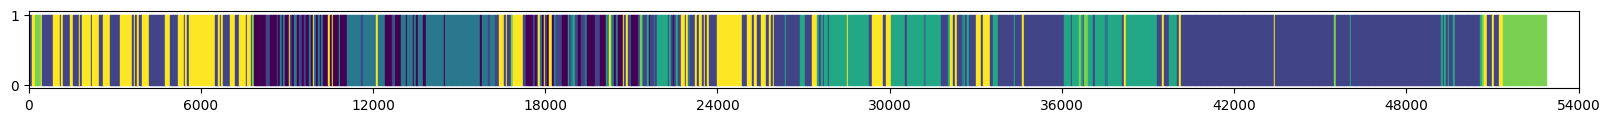

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# 给定的数字列表
segments = df["label"]

# 获取列表中的唯一值和它们的颜色映射
unique_vals = np.unique(segments)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_vals)))
color_map = dict(zip(unique_vals, colors))

# 为进度条的每一段选择颜色
segment_colors = [color_map[val] for val in segments]

# 绘制进度条
fig, ax = plt.subplots(figsize=(20, 1))
ax.axis('on')  # 关闭坐标轴

for i, (seg, color) in enumerate(zip(segments, segment_colors)):
    ax.fill_between([i, i+1], 0, 1, color=color)

# 设置x轴的限制从0开始
ax.set_xlim(0, len(segments))

# 调整x轴的刻度标签为其30倍
locs = ax.get_xticks()  # 获取当前的x轴刻度位置
ax.set_xticks(locs)
ax.set_xticklabels([int(loc * 60) for loc in locs])

plt.show()

In [62]:
lab = 0
dict = {}

for v in df['v'].unique():
    if v not in dict.keys():
        dict[v] = lab
        lab+=1

dict_keys(['a'])